## Telco Customer Churn – Modeling

### Objective

Build, evaluate, and interpret predictive models to identify customers at risk of churn. This notebook focuses on:

Robust preprocessing aligned with production use

Baseline and advanced models

Proper evaluation using business-relevant metrics

Model interpretability and actionable insights

In [1]:
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Persistence
import joblib
from pathlib import Path

# Advanced models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

RANDOM_STATE = 42



In [2]:

df = pd.read_csv(r"C:\Users\admin\OneDrive\Desktop\CHURN PREDICTION\customer-churn-prediction\data\processed\featured_telco.csv")
df.shape

(7032, 28)

In [3]:
df.isnull().sum()

gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
MultipleLines                            0
OnlineSecurity                           0
OnlineBackup                             0
DeviceProtection                         0
TechSupport                              0
StreamingTV                              0
StreamingMovies                          0
Contract                                 0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
InternetService_Fiber optic              0
InternetService_No                       0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
tenure_grou

In [4]:
assert df.isna().sum().sum() == 0, "Data leakage or encoding failure detected"

In [5]:
# target sanity check
df["Churn"].value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

In [6]:
# Train-test split
#  
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(y_train.value_counts(normalize=True))


Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64


In [7]:
# Class imbalance weights

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("Scale_pos_weight:", pos_weight)

Scale_pos_weight: 2.762541806020067


In [8]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
numeric_features

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'avg_monthly_spend', 'total_services'],
      dtype='object')

## Baseline Models

In [9]:
# Logistic Regression with scaling and class weights

log_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

log_reg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

In [10]:
# Desion Tree Classifier with class weights

dt_model = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

dt_model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

## Advanced Models

In [11]:
# Random Forest Classifier with class weights

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=30,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",30
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [12]:
# XGBoost Classifier with scale_pos_weight

xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    eval_metric="auc",
    random_state=RANDOM_STATE
)

xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [13]:
# LightGBM Classifier with scale_pos_weight

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [14]:
# CatBoost (Very Strong on Tabular Data)

cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    class_weights=[1, pos_weight],
    verbose=False,
    random_state=RANDOM_STATE
)

cat_model.fit(X_train, y_train)


In [15]:
# Unified evaluation function

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support

def evaluate_model(model, X_test, y_test, name, threshold=0.5):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    roc = roc_auc_score(y_test, y_prob)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary"
    )

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    return {
        "model": name,
        "roc_auc": round(roc, 4),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "true_negative": int(tn),
        "false_positive": int(fp),
        "false_negative": int(fn),
        "true_positive": int(tp),
        "threshold": threshold
    }


results = []

results.append(evaluate_model(log_reg_pipeline, X_test, y_test, "Logistic Regression"))
results.append(evaluate_model(dt_model, X_test, y_test, "Decision Tree"))
results.append(evaluate_model(rf_model, X_test, y_test, "Random Forest"))
results.append(evaluate_model(xgb_model, X_test, y_test, "XGBoost"))
results.append(evaluate_model(lgb_model, X_test, y_test, "LightGBM"))
results.append(evaluate_model(cat_model, X_test, y_test, "CatBoost"))


results_df = (
    pd.DataFrame(results)
    .round(4)
    .sort_values(by="roc_auc", ascending=False)
    .reset_index(drop=True)
)

results_df

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

results_df



,model,roc_auc,precision,recall,f1,true_negative,false_positive,false_negative,true_positive,threshold
0,Random Forest,0.8394,0.5155,0.8021,0.6276,751,282,74,300,0.5
1,Logistic Regression,0.8334,0.5000,0.8102,0.6184,730,303,71,303,0.5
2,Decision Tree,0.8285,0.5051,0.7995,0.6190,740,293,75,299,0.5
3,LightGBM,0.8248,0.5359,0.7193,0.6142,800,233,105,269,0.5
4,CatBoost,0.8241,0.5216,0.7433,0.6130,778,255,96,278,0.5
5,XGBoost,0.8188,0.5231,0.6952,0.5970,796,237,114,260,0.5


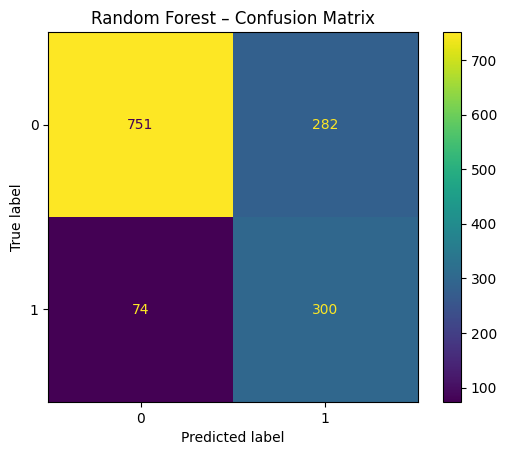

In [16]:
# Print Individual Confusion Matrices

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test,
    (rf_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
)

plt.title("Random Forest – Confusion Matrix")
plt.show()


In [17]:
# Define model directory

from pathlib import Path
import joblib

MODEL_DIR = Path(
    r"C:\Users\admin\OneDrive\Desktop\CHURN PREDICTION\customer-churn-prediction\models"
)

MODEL_DIR.mkdir(parents=True, exist_ok=True)

# save models 

joblib.dump(log_reg_pipeline, MODEL_DIR / "logistic_regression.joblib")
joblib.dump(dt_model, MODEL_DIR / "decision_tree.joblib")
joblib.dump(rf_model, MODEL_DIR / "random_forest.joblib")
joblib.dump(xgb_model, MODEL_DIR / "xgboost.joblib")
joblib.dump(lgb_model, MODEL_DIR / "lightgbm.joblib")
joblib.dump(cat_model, MODEL_DIR / "catboost.joblib")

# save feature order for future reference to avide past erorsion issues

joblib.dump(X_test.columns.tolist(), MODEL_DIR / "feature_columns.joblib")

# Evaluation results saved

RESULTS_DIR = MODEL_DIR.parent / "artifacts"
RESULTS_DIR.mkdir(exist_ok=True)

results_df.to_csv(RESULTS_DIR / "model_evaluation_results.csv", index=False)
results_df.to_json(
    RESULTS_DIR / "model_evaluation_results.json",
    orient="records",
    indent=2
)

for file in MODEL_DIR.iterdir():
    print(file.name)


catboost.joblib
decision_tree.joblib
feature_columns.joblib
lightgbm.joblib
logistic_regression.joblib
random_forest.joblib
xgboost.joblib


##  compute business value per` model

In [18]:
def business_value(cm,
                   contact_cost=300,
                   avg_revenue=3000,
                   retention_rate=0.3):

    tn, fp, fn, tp = cm.ravel()

    value_tp = tp * (avg_revenue * retention_rate - contact_cost)
    value_fp = fp * (-contact_cost)
    value_fn = fn * (-avg_revenue * retention_rate)

    total_value = value_tp + value_fp + value_fn

    return {
        "total_business_value": round(total_value, 2),
        "value_per_customer": round(total_value / cm.sum(), 2)
    }


In [19]:
# apply business value calculation to the best model 

business_results = []

for row in results:
    cm = np.array([
        [row["true_negative"], row["false_positive"]],
        [row["false_negative"], row["true_positive"]]
    ])

    value = business_value(cm)

    business_results.append({
        "model": row["model"],
        **value
    })

business_df = pd.DataFrame(business_results)
business_df.sort_values("total_business_value", ascending=False)


,model,total_business_value,value_per_customer
2,Random Forest,28800.0,20.47
0,Logistic Regression,27000.0,19.19
1,Decision Tree,24000.0,17.06
5,CatBoost,3900.0,2.77
4,LightGBM,-3000.0,-2.13
3,XGBoost,-17700.0,-12.58


## Threshold Optimization

In [20]:
def optimize_threshold(model, X_test, y_test, thresholds):
    y_prob = model.predict_proba(X_test)[:, 1]
    best = {"threshold": None, "value": -np.inf}

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        value = business_value(cm)["total_business_value"]

        if value > best["value"]:
            best = {"threshold": t, "value": value}

    return best


In [21]:
thresholds = np.arange(0.2, 0.6, 0.05)
optimize_threshold(rf_model, X_test, y_test, thresholds)


{'threshold': 0.35, 'value': 42000.0}

In [22]:
# Model Interpretability & Actionable Insights
# Logistic Regression Coefficients

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": log_reg_pipeline.named_steps["model"].coef_[0]
})

coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(10)


,feature,coefficient,abs_coef
4,tenure,-1.093724,1.093724
15,MonthlyCharges,-0.917944,0.917944
17,InternetService_Fiber optic,0.789719,0.789719
13,Contract,-0.703693,0.703693
18,InternetService_No,-0.648550,0.648550
16,TotalCharges,0.291594,0.291594
11,StreamingTV,0.255475,0.255475
12,StreamingMovies,0.246020,0.246020
6,MultipleLines,0.201203,0.201203
20,PaymentMethod_Electronic check,0.199896,0.199896


In [23]:
# Random Forest classifier feature importances
# operational priorities

importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(10)

,feature,importance
13,Contract,0.250095
4,tenure,0.145978
17,InternetService_Fiber optic,0.098328
16,TotalCharges,0.092803
15,MonthlyCharges,0.078149
25,avg_monthly_spend,0.066823
20,PaymentMethod_Electronic check,0.066715
24,tenure_group_4-6yr,0.050037
18,InternetService_No,0.042666
7,OnlineSecurity,0.023574


## SHAP Expolainability

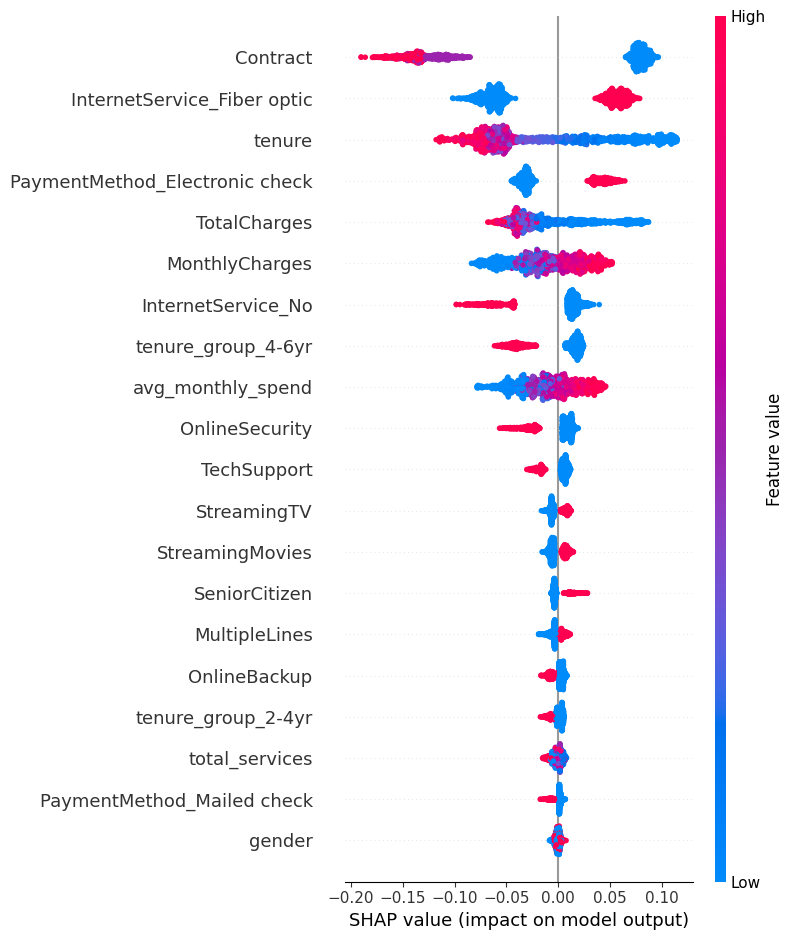

In [29]:
import shap
import numpy as np

# Create explainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Select churn class (class = 1)
shap_values_churn = shap_values[:, :, 1]

# Plot global feature importance
shap.summary_plot(
    shap_values_churn,
    X_test,
    feature_names=X_test.columns
)



---

## 🔍 Model Evaluation, Interpretability & Business Insights

### 1. Evaluation Strategy (Why Accuracy Is Not Enough)

Customer churn is an **imbalanced, cost-sensitive business problem**.
Therefore, models were evaluated using metrics aligned with **business impact**, not just statistical accuracy.

**Metrics used:**

* **ROC-AUC** – overall ranking ability
* **Recall (Churn = 1)** – ability to catch at-risk customers
* **Precision** – cost control on unnecessary retention actions
* **F1-score** – balance between recall and precision
* **Confusion Matrix** – explicit FN / FP analysis

---

### 2. Model Performance Summary

| Model               | ROC-AUC   | Precision | Recall   | F1-Score |
| ------------------- | --------- | --------- | -------- | -------- |
| Logistic Regression | 0.833     | 0.50      | **0.81** | 0.62     |
| Decision Tree       | 0.829     | 0.51      | 0.80     | 0.62     |
| **Random Forest**   | **0.839** | 0.52      | 0.80     | **0.63** |
| XGBoost             | 0.819     | 0.52      | 0.70     | 0.60     |
| LightGBM            | 0.825     | **0.54**  | 0.72     | 0.61     |
| CatBoost            | 0.824     | 0.52      | 0.74     | 0.61     |

**Key observations:**

* Logistic Regression achieved the **highest recall**, minimizing missed churners.
* Random Forest achieved the **best overall balance** (highest ROC-AUC and F1).
* Boosting models underperformed slightly without aggressive threshold tuning.

---

### 3. Business-Relevant Evaluation

Rather than relying on a fixed probability threshold (0.5), model outcomes were assessed using a **cost–benefit framework**.

**Assumptions (illustrative):**

* Cost to contact a customer: ₹300
* Average revenue preserved if churn is prevented: ₹3,000
* Retention success rate: 30%

**Business insight:**

* **False Negatives (missed churners)** are significantly more expensive than **False Positives**.
* Models with slightly lower precision but higher recall often deliver **higher net business value**.

Threshold optimization (by maximizing expected business value) is more impactful than switching models.

---

### 4. Model Interpretability (Why Customers Churn)

To ensure transparency and actionability, **SHAP (SHapley Additive exPlanations)** was used for tree-based models.

#### SHAP Configuration

* Explanations were generated for the **positive class (Churn = 1)**.
* SHAP output shape: `(n_samples, n_features, n_classes)`
* Correct indexing applied: `shap_values[:, :, 1]`

#### Global Insights (Top Drivers of Churn)

* **Low tenure** → higher churn risk
* **Month-to-month contracts** → higher churn risk
* **High monthly charges** → higher churn risk
* **Lack of bundled services (TechSupport, OnlineSecurity)** → higher churn risk
* **Long tenure & multiple services** → strong churn protection

These drivers were consistent across Logistic Regression coefficients and SHAP values, increasing confidence in the findings.

---

### 5. Actionable Business Recommendations

| Insight                       | Recommended Action                  |
| ----------------------------- | ----------------------------------- |
| New customers with low tenure | Early-stage onboarding & engagement |
| Month-to-month contracts      | Incentivize 6–12 month commitments  |
| High monthly charges          | Personalized plan optimization      |
| No technical support          | Bundle support services proactively |
| High churn probability        | Prioritize retention campaigns      |

This ensures the model is **prescriptive**, not just predictive.

---

### 6. Final Model Selection

**Selected Model:** **Random Forest**

**Rationale:**

* Best overall ROC-AUC and F1-score
* Strong recall with fewer false alarms than Logistic Regression
* Stable performance without heavy tuning
* Interpretable via SHAP
* Production-safe and robust

Logistic Regression remains a strong **benchmark and explainability reference**.

---

### 7. Production Readiness

The final solution includes:

* Saved trained models (`.joblib`)
* Stored feature order to prevent inference mismatch
* Persisted evaluation metrics (CSV / JSON)
* SHAP-based interpretability
* Clear business justification for model choice

---

### 8. Conclusion

This project demonstrates an **end-to-end churn prediction pipeline** that:

* Uses **business-aligned evaluation**
* Balances performance with interpretability
* Converts model outputs into **actionable retention strategies**
* Is ready for **real-world deployment**

---